# Analysis of v-bottom well motility assay
---

### Overview

This notebook provides a comprehensive analysis of motility assay data from *Chlamydomonas* strains seeded in 96- or 384-well conical (V) bottom plates, captured by a [Phenotype-o-mat setup](https://doi.org/10.57844/arcadia-112f-5023). The underlying principle of this assay is that non-motile cells should collect at the bottom of the well (in the center), while motile cells should remain suspended in liquid. The intensity profile of images of wells with non-motile cells should therefore have dark centers and relatively lighter edges, while the intensity profile of images of wells with motile cells should be relatively uniform (see [Figure 2A](https://doi.org/10.57844/arcadia-fe2a-711e) of the pub for a visual explanation). The output from the Phenotype-o-mat is a single-frame AVI file (i.e. a grayscale image) of all 96 or 384 v-bottom wells. 

The v-bottom well motility assay was done twice: once on wild-type and mutant *Chlamydomonas* strains treated with only controls (Figure 2) and once on the same *Chlamydomonas* strains treated with either controls or drugs (Figure 4). In both instances, the Phenotype-o-mat was used to record a 96 frame time-lapse of the cells in which an image was recorded every minute. Only the final frame of the time-lapse is considered for this anlaysis as it is was determined empirically that the intensity profiles remain constant after 50 or so frames.

This notebook performs the following analysis for both instances of the v-bottom motility assay:

1. **Extract and visualize intensity profiles**:
   Measures the intensity from horizontal line scans across the wells to quantify cell density, differentiating between non-motile cells (which sink to the bottom of the well) and motile cells (which remain suspended).

2. **Calculate and visualize distributions of motility ratios**:
   The motility ratio is calculated from the intensity profiles as a means of estimating the fraction of cells that are non-motile. Different combinations of strain and drug treatment result in different distributions of motility ratios.

3. **Statistical testing**:
   Generates violin plots of motility fractions and performs either Kruskal-Wallis and Dunn's post-hoc tests with Bonferroni correction or one-way ANOVA and post-hoc Tukey tests to evaluate differences between treatments across multiple strains.

Output from this notebook was used to generate Figures 2 and 4 in the [publication](https://doi.org/10.57844/arcadia-fe2a-711e) as well as statistical analysis throughout the text. ChatGPT was used to draft portions of the code in this notebook.

In [1]:
import sys
from itertools import product
from pathlib import Path

import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import skimage as ski
from scikit_posthocs import posthoc_dunn
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Add local code to path
sys.path.insert(0, "../src")
import vbottom

# Set the default matplotlib styles using arcadia-pycolor
apc.mpl.setup()

## Figure 2
---
Wild-type and mutant *Chlamydomonas* strains treated with only **controls**.

**Strains**:
- CC-125: wild type
- CC-2670: *ida4* mutant
- CC-3707: *cpc1-1* mutant

**Controls**:
- Water
- 0.1% DMSO

*Prior to this analysis, I opened the last single-frame AVI acquired in the dataset in FIJI and cropped the image to only include the wells of interest. I then saved the image as a TIF.*

### 1. Extract intensity profiles
Intensity values are normalized to the average intensity per well to correct for variation in culture density.

In [2]:
# Load Phenotype-o-mat image
image_filepath = Path(
    "../data/vbottom_motility_assay/cropped_final_frames/"
    "algae_growth_curve_00000_1722972387-1_FinalFrame_Crop.tif"
)
image = ski.io.imread(image_filepath)

# Parameters for extracting intensity profiles from v-bottom well plates
num_rows = 6
num_cols = 11
scan_width = 10
scan_length = 40

# Get the intensity profile from each well
well_centers, intensity_profiles = vbottom.get_well_intensity_profiles(
    image,
    num_rows,
    num_cols,
    scan_width=scan_width,
    scan_length=scan_length,
    normalize=True,
)

### Annotate Phenotype-o-mat image

Overlay the ROIs defined for extracting the intensity profile from each well. Add a label for the strain of each cell in the corresponding v-bottom well.

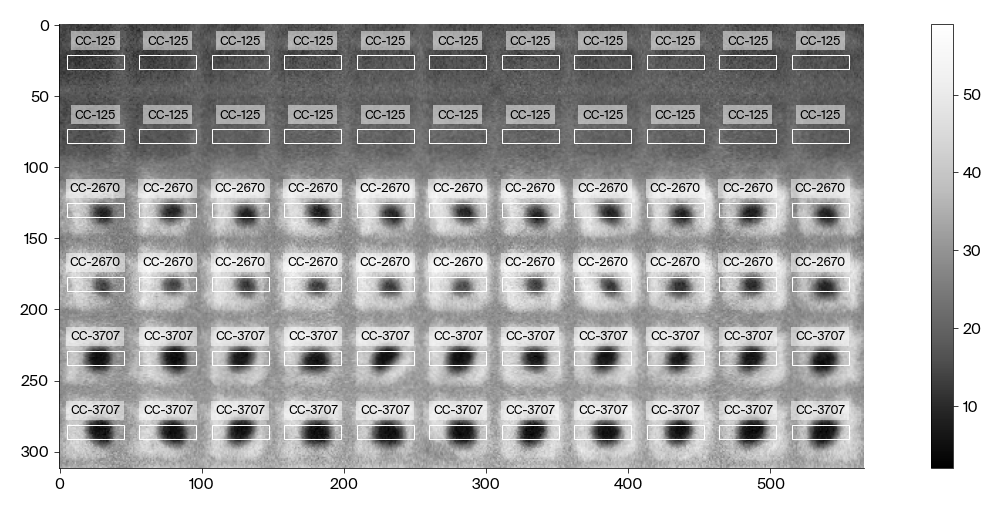

In [3]:
# Labels for the strain of cells within each well
labels = [
    ["CC-125"] * num_cols,
    ["CC-125"] * num_cols,
    ["CC-2670"] * num_cols,
    ["CC-2670"] * num_cols,
    ["CC-3707"] * num_cols,
    ["CC-3707"] * num_cols,
]
flat_labels = [label for row in labels for label in row]

# Annotate Phenotype-o-mat image
vbottom.annotate_phenotypeomat_image(
    image,
    well_centers,
    flat_labels,
    scan_width,
    scan_length,
    savefig_filepath="../results/linescan_strain_results/vbottom_wells_annotated.png",
    mpl_text_kwargs={
        "color": "black",
        "bbox": {"facecolor": "white", "alpha": 0.5},
    },
)

### Visualize intensity profiles

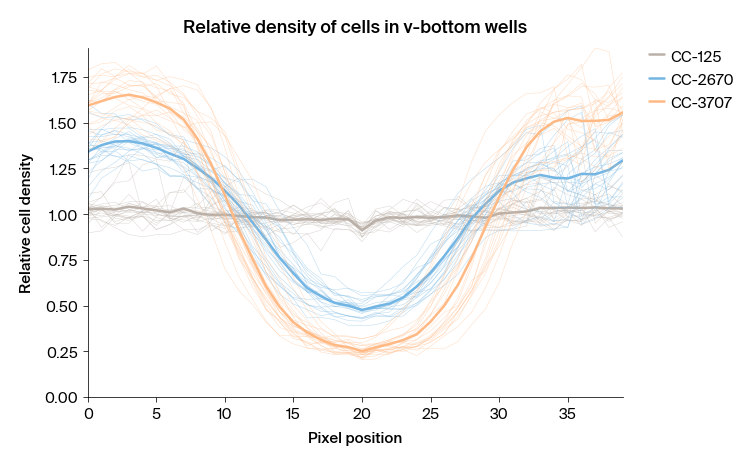

In [4]:
# Define color map for each strain
strains = ["CC-125", "CC-2670", "CC-3707"]
colors = ["#BAB0A8", "#73B5E3", "#FFB984"]
colormap = {strain: color for strain, color in zip(strains, colors, strict=True)}

# Map intensity profiles to each strain
intensity_profiles_strain_map = {}
for strain in strains:
    intensity_profiles_per_strain = np.array(
        [intensity_profiles[i] for i in range(len(intensity_profiles)) if flat_labels[i] == strain]
    )
    intensity_profiles_strain_map[strain] = intensity_profiles_per_strain

# Plot the intensity profiles of each strain
fig, ax = plt.subplots(layout="constrained", figsize=(10, 6))
for strain, intensity_profiles_per_strain in intensity_profiles_strain_map.items():
    # Plot each intensity profile as semi-transparent
    for intensity_profile in intensity_profiles_per_strain:
        ax.plot(intensity_profile, color=colormap[strain], lw=0.5, alpha=0.5)

    # Average intensity profile more bold
    average_intensity_profile = np.mean(intensity_profiles_per_strain, axis=0)
    ax.plot(average_intensity_profile, color=colormap[strain], lw=2.5, label=f"{strain}")

# Aesthetics
ax.set_title("Relative density of cells in v-bottom wells")
ax.set_xlabel("Pixel position")
ax.set_ylabel("Relative cell density")
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax.set_xlim(0, scan_length - 1)
ax.set_ylim(0, np.max(intensity_profiles))

# Save figure
savefig_filepath = "../results/figure-2B.pdf"
apc.mpl.save_figure(savefig_filepath)

### 2. Compute and visualize motility ratios

The motility ratio, defined as the ratio of intensity values in the outer edge of the well to the minimum intensity value of the pellet, is an estimate of the fraction of non-motile cells. Here we generate violin plots showing the distribution of motility ratios between strains.

As described in the pub,
> To estimate the fraction of non-motile cells (periphery-to-pellet intensity ratio or motility ratio), we divided the average intensity of the peripheral tail (defined as the range of pixels between positions 33 & 37 of the 40-pixel line scan) of our line scans by the minimal intensity value of each line scan. This analysis revealed significantly more non-motile ida4 cells and cpc1-1 cells compared to wild-type cells.


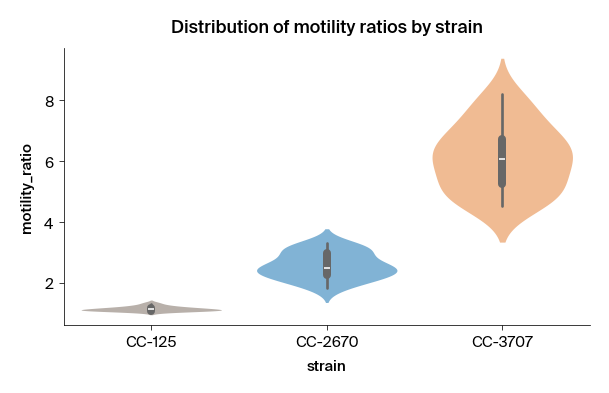

In [5]:
# Define the "periphery" region: tail end of the intensity profile where only motile cells will be
periphery_region = np.arange(33, 38)

# Calculate the periphery-to-pellet intensity ratio ("motility ratio") for each well and
# map to the corresponding strain
motility_ratios_strain_map = {}
for strain, intensity_profiles_per_strain in intensity_profiles_strain_map.items():
    mean_periphery_intensities = intensity_profiles_per_strain[:, periphery_region].mean(axis=1)
    min_pellet_intensities = intensity_profiles_per_strain.min(axis=1)
    motility_ratio = mean_periphery_intensities / min_pellet_intensities
    motility_ratios_strain_map[strain] = motility_ratio

# Convert dictionary of motility ratio data to long-form pandas DataFrame for compatibility
# with seaborn violin plot
motility_ratios_dataframe = pd.DataFrame(motility_ratios_strain_map).melt(
    var_name="strain", value_name="motility_ratio"
)

# Create violin plot
fig, ax = plt.subplots(layout="constrained", figsize=(8, 5))
ax = sns.violinplot(
    data=motility_ratios_dataframe,
    x="strain",
    y="motility_ratio",
    hue="strain",
    palette=colormap,
    inner="box",
    inner_kws={"box_width": 8},
)
_ = ax.set_title("Distribution of motility ratios by strain")

# Save figure
savefig_filepath = "../results/figure-2C.pdf"
apc.mpl.save_figure(savefig_filepath)

### 3. Perform statistical tests

This statistical testing workflow begins with a Kruskal-Wallis H-test to assess whether there are significant differences among the motility ratios of cells within each strain. If the test is statistically significant (indicating at least one group differs from the others), Dunn's test (post-hoc pairwise test for multiple comparisons of mean rank sums) is performed as a post-hoc analysis with Bonferroni correction.

In [6]:
# Set significance threshold for the test
alpha = 0.05

# Kruskal-Wallis
samples = [
    group["motility_ratio"].values for _strain, group in motility_ratios_dataframe.groupby("strain")
]
kruskal_results = stats.kruskal(*samples)
kruskal_report = (
    f"Kruskal-Wallis result for motility ratios:\n"
    f"H-statistic: {kruskal_results.statistic:.3g}, p-value: {kruskal_results.pvalue:.3g}"
)
print(kruskal_report)

if kruskal_results.pvalue < alpha:
    # Dunn's test
    dunn_results = posthoc_dunn(
        motility_ratios_dataframe,
        val_col="motility_ratio",
        group_col="strain",
        p_adjust="bonferroni",
    )
    print("-" * 50, "\nDunn's post-hoc test results with adjusted p-values:\n", dunn_results)

Kruskal-Wallis result for motility ratios:
H-statistic: 57.8, p-value: 2.82e-13
-------------------------------------------------- 
Dunn's post-hoc test results with adjusted p-values:
                CC-125   CC-2670       CC-3707
CC-125   1.000000e+00  0.000432  8.744813e-14
CC-2670  4.323031e-04  1.000000  4.323031e-04
CC-3707  8.744813e-14  0.000432  1.000000e+00


## Figure 4
---
Wild-type and mutant *Chlamydomonas* strains treated with **controls and drugs**.

**Strains** (same as in Figure 2 analysis):
- CC-125: wild type
- CC-2670: *ida4* mutant
- CC-3707: *cpc1-1* mutant

**Controls** (same as in Figure 2 analysis):
- Water
- 0.1% DMSO

**Drugs**:
- Torin2
- TAK-063
- Dynarrestin
- ATP
- Linsitinib
- Ibudilast

All drug concentrations were 50 µM.

*Prior to this analysis, I opened the last single-frame AVI acquired in the dataset in FIJI and cropped the image to only include the wells of interest. I then saved the image as a TIF.*

### 1. Extract intensity profiles
Unlike in the analysis for Figure 2, here the intensity values are **not** normalized to the average intensity per well in order to highlight drug-induced growth effects which would otherwise be suppressed.

In [7]:
# Load Phenotype-o-mat image
image_filepath = Path(
    "../data/vbottom_motility_assay/cropped_final_frames/"
    "algae_growth_curve_00000_1724619978-Crop.tif"
)
image = ski.io.imread(image_filepath)

# Parameters for extracting intensity profiles from v-bottom well plates
num_rows = 6
num_cols = 12
scan_width = 10
scan_length = 40

# Get the intensity profile from each well
well_centers, intensity_profiles = vbottom.get_well_intensity_profiles(
    image,
    num_rows,
    num_cols,
    scan_width=scan_width,
    scan_length=scan_length,
    normalize=False,
)

### Annotate Phenotype-o-mat image

Overlay the ROIs defined for extracting the intensity profile from each well. Add a label for the strain of each cell in the corresponding v-bottom well.

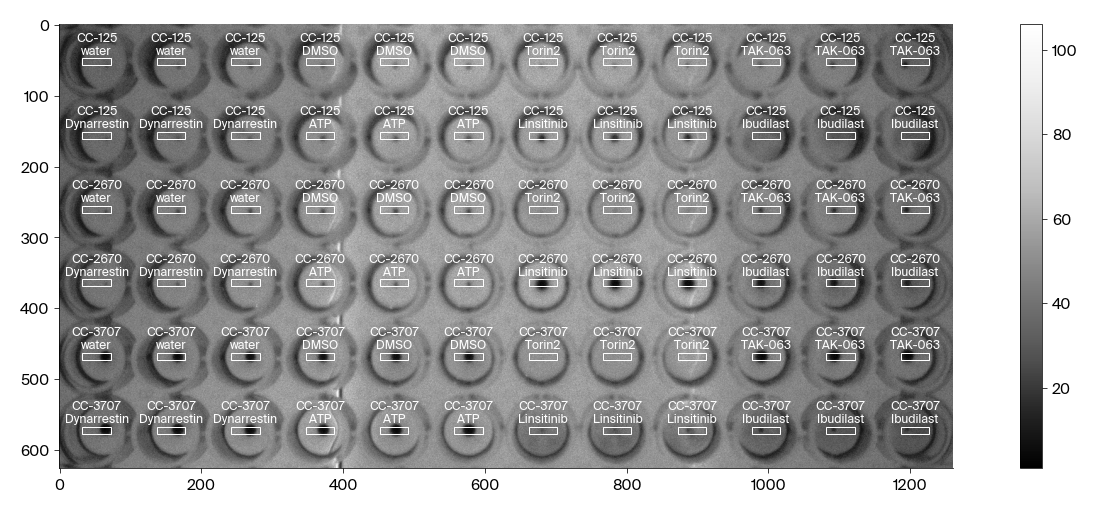

In [13]:
# Labels for the strain and drug/treatment of cells within each well
num_replicates = 3
controls = [
    "water",
    "DMSO",
]
drugs = [
    "Torin2",
    "TAK-063",
    "Dynarrestin",
    "ATP",
    "Linsitinib",
    "Ibudilast",
]
treatments = controls + drugs
labels = [
    [f"{strain}\n{treatment}"] * num_replicates
    for strain, treatment in product(strains, treatments)
]
# Flatten the list of lists
flat_labels = [label for row in labels for label in row]

# Annotate Phenotype-o-mat image
vbottom.annotate_phenotypeomat_image(
    image,
    well_centers,
    flat_labels,
    scan_width,
    scan_length,
    y_offset_label=25,
    savefig_filepath="../results/linescan_drug_results/vbottom_wells_annotated.png",
)

### Visualize intensity profiles

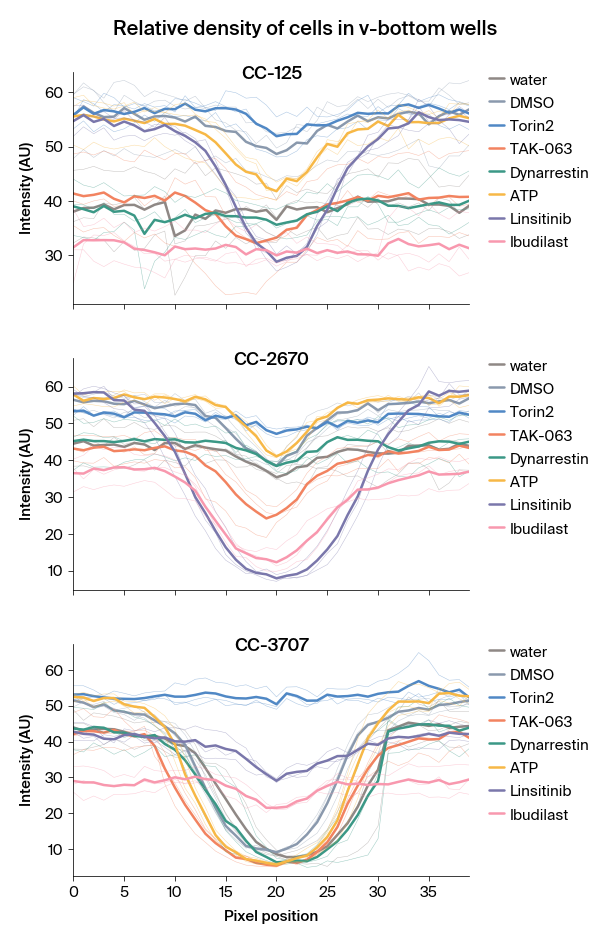

In [9]:
# Define the color scheme for treatments
treatment_colormap = {
    "water": "#8F8885",
    "DMSO": "#8A99AD",
    "Torin2": "#5088C5",
    "TAK-063": "#F28360",
    "Dynarrestin": "#3B9886",
    "ATP": "#F7B846",
    "Linsitinib": "#7A77AB",
    "Ibudilast": "#F898AE",
}

# Map triplicate intensity profiles to each (strain, treatment) combination
# --> 24 (strain, treatment) combinations with 3 intensity profiles per combo
strain_treatment_pairs = [tuple(label.split("\n")) for label in flat_labels]
intensity_profiles_map = {k: [] for k in strain_treatment_pairs}
for pair, intensity_profile in zip(strain_treatment_pairs, intensity_profiles, strict=True):
    intensity_profiles_map[pair].append(intensity_profile)

# Create figure with a subplot for each strain
nrows = len(strains)
fig, axes = plt.subplots(
    nrows=nrows,
    sharex=True,
    layout="constrained",
    figsize=(8, 4 * nrows),
    gridspec_kw={"hspace": 0.15},
)
axes_map = {strain: ax for strain, ax in zip(strains, axes.flat, strict=True)}

# Loop through each strain, treatment combination and plot the intensity profiles
for (strain, treatment), intensity_profile_set in intensity_profiles_map.items():
    for intensity_profile in intensity_profile_set:
        # Plot each intensity profile lightly
        axes_map[strain].plot(
            intensity_profile, color=treatment_colormap[treatment], linewidth=0.5, alpha=0.5
        )

    # Calculate and plot the average intensity profile per strain, treatment combo
    average_intensity_profile = np.mean(intensity_profile_set, axis=0)
    axes_map[strain].plot(
        average_intensity_profile,
        color=treatment_colormap[treatment],
        linewidth=2.5,
        label=treatment,
    )

# Aesthetics
fig.suptitle("Relative density of cells in v-bottom wells", fontsize=20, y=1.05)
axes.flat[-1].set_xlabel("Pixel position")
[ax.set_ylabel("Intensity (AU)") for ax in axes.flat]
# [ax.set_title(titles[i]) for i, ax in enumerate(axes.flat)]
[ax.set_title(strain, y=0.9) for strain, ax in axes_map.items()]
[ax.set_xlim(0, scan_length - 1) for ax in axes.flat]
_ = [ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1)) for ax in axes.flat]

# Save figure
savefig_filepath = "../results/figure-4A.pdf"
apc.mpl.save_figure(savefig_filepath)

### 2. Compute and visualize motility ratios

In [10]:
# Calculate the periphery-to-pellet intensity ratio ("motility ratio") for each well and
# map to the corresponding strain
motility_ratios_dataframe = pd.DataFrame()
i = 0
for (strain, treatment), intensity_profiles_set in intensity_profiles_map.items():
    for intensity_profile in intensity_profiles_set:
        # Calculate the motility ratio
        mean_periphery_intensity = intensity_profile[periphery_region].mean()
        min_pellet_intensity = intensity_profile.min()
        motility_ratio = mean_periphery_intensity / min_pellet_intensity
        # Append to DataFrame
        motility_ratios_dataframe.loc[i, "strain"] = strain
        motility_ratios_dataframe.loc[i, "treatment"] = treatment
        motility_ratios_dataframe.loc[i, "motility_ratio"] = motility_ratio

        i += 1

# Preview DataFrame of motility ratios
motility_ratios_dataframe.sample(5)

,strain,treatment,motility_ratio
14,CC-125,Dynarrestin,1.149882
58,CC-3707,TAK-063,7.345161
42,CC-2670,Linsitinib,6.353061
15,CC-125,ATP,1.268934
43,CC-2670,Linsitinib,6.823529


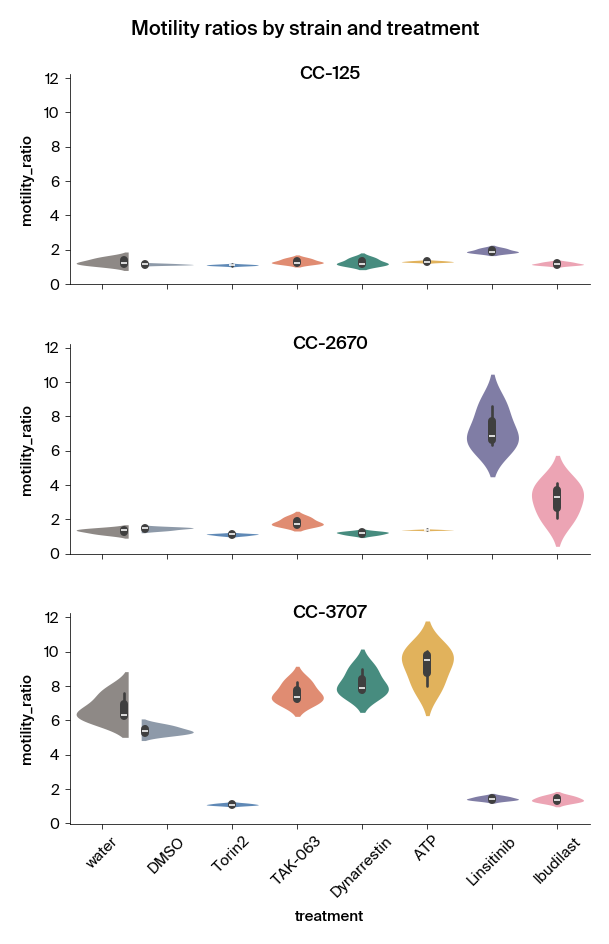

In [11]:
# Create figure with a subplot for each strain
nrows = len(strains)
fig, axes = plt.subplots(
    nrows=nrows,
    sharex=True,
    sharey=True,
    layout="constrained",
    figsize=(8, 4 * nrows),
    gridspec_kw={"hspace": 0.15},
)
axes_map = {strain: ax for strain, ax in zip(strains, axes.flat, strict=True)}

for strain in strains:
    # Plot controls and drugs separately
    source_controls = motility_ratios_dataframe.loc[
        (motility_ratios_dataframe["strain"] == strain)
        & (motility_ratios_dataframe["treatment"].isin(controls))
    ]
    source_drugs = motility_ratios_dataframe.loc[
        (motility_ratios_dataframe["strain"] == strain)
        & (motility_ratios_dataframe["treatment"].isin(drugs))
    ]

    # Violin plot for controls
    ax = sns.violinplot(
        data=source_controls,
        x="treatment",
        y="motility_ratio",
        hue="treatment",
        palette=treatment_colormap,
        split=True,
        inner="box",
        inner_kws={"box_width": 8},
        ax=axes_map[strain],
    )
    # Violin plot for drugs
    ax = sns.violinplot(
        data=source_drugs,
        x="treatment",
        y="motility_ratio",
        hue="treatment",
        palette=treatment_colormap,
        split=False,
        inner="box",
        inner_kws={"box_width": 8},
        ax=axes_map[strain],
    )

# Aesthetics
fig.suptitle("Motility ratios by strain and treatment", fontsize=20, y=1.05)
[ax.set_title(strain, y=0.9) for strain, ax in axes_map.items()]
_ = [ax.xaxis.set_tick_params(rotation=45) for ax in axes.flat]

# Save figure
savefig_filepath = "../results/figure-4B.pdf"
apc.mpl.save_figure(savefig_filepath)

### 3. Perform statistical tests

This statistical testing workflow begins with a one-way ANOVA to assess whether there are significant differences among the motility ratios of cells with different treatments within each strain. If the ANOVA result is statistically significant (indicating at least one group differs from the others), a Tukey's Honestly Significant Difference (HSD) test is performed as a post-hoc analysis. Tukey’s HSD conducts pairwise comparisons between all groups to pinpoint specific group differences, adjusting for multiple comparisons to maintain a consistent significance level.

In [12]:
# Set significance threshold for the test
alpha = 0.05

# Assess whether there are significant differences among motility ratios
for strain, group in motility_ratios_dataframe.groupby("strain"):
    print(f"\n-------------- Statistical analysis for {strain} ---------------")

    # ANOVA
    samples = [
        group.groupby("treatment").get_group(treatment)["motility_ratio"].values
        for treatment in treatments
    ]
    anova_result = stats.f_oneway(*samples)
    anova_report = (
        f"ANOVA result for motility ratio in {strain}: F={anova_result.statistic:.3g}, "
        f"p={anova_result.pvalue:.3g}"
    )
    print(anova_report)

    # Tukey's HSD
    if anova_result.pvalue < alpha:
        tukey_result = pairwise_tukeyhsd(
            group["motility_ratio"], groups=group["treatment"], alpha=alpha
        )
        print(tukey_result)


-------------- Statistical analysis for CC-125 ---------------
ANOVA result for motility ratio in CC-125: F=12.3, p=2.23e-05
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
        ATP        DMSO  -0.1607 0.7718 -0.5199  0.1985  False
        ATP Dynarrestin  -0.0421 0.9999 -0.4013  0.3172  False
        ATP   Ibudilast  -0.1281 0.9094 -0.4873  0.2311  False
        ATP  Linsitinib   0.6154 0.0004  0.2561  0.9746   True
        ATP     TAK-063   0.0018    1.0 -0.3574   0.361  False
        ATP      Torin2  -0.2026 0.5381 -0.5618  0.1566  False
        ATP       water  -0.0138    1.0  -0.373  0.3454  False
       DMSO Dynarrestin   0.1186 0.9368 -0.2406  0.4779  False
       DMSO   Ibudilast   0.0326    1.0 -0.3266  0.3918  False
       DMSO  Linsitinib    0.776    0.0  0.4168  1.1353   True
       DMSO     TAK-063   0.1625 0.7626 -0.1967  0.5217